Import necessary libraries for data manipulation and visualization. 

In [137]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import pprint
from scipy import stats
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.utils import resample
from xgboost import XGBClassifier
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.pipeline import Pipeline
from xgboost import plot_importance
from sklearn.tree import export_text
from sklearn.metrics import confusion_matrix


Load the transaction data from an Excel file into a DataFrame for analysis.

In [81]:
# Setting to display all columns of a DataFrame
pd.set_option('display.max_columns', None)

# Loading data from an Excel file
df0 = pd.read_excel('PSP_Jan_Feb_2019.xlsx')
df_rawdata = df0.copy()

In [82]:
# Displaying the first few rows of the dataframe
print(df0.head())

# Printing information about the dataframe including the dtype and columns, non-null values
print(df0.info())

# Printing descriptive statistics that summarize the central tendency, dispersion, and shape of the dataframe's distribution
print(df0.describe())


   Unnamed: 0                tmsp  country  amount  success         PSP  \
0           0 2019-01-01 00:01:11  Germany      89        0     UK_Card   
1           1 2019-01-01 00:01:17  Germany      89        1     UK_Card   
2           2 2019-01-01 00:02:49  Germany     238        0     UK_Card   
3           3 2019-01-01 00:03:13  Germany     238        1     UK_Card   
4           4 2019-01-01 00:04:33  Austria     124        0  Simplecard   

   3D_secured    card  
0           0    Visa  
1           0    Visa  
2           1  Diners  
3           1  Diners  
4           0  Diners  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50410 entries, 0 to 50409
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Unnamed: 0  50410 non-null  int64         
 1   tmsp        50410 non-null  datetime64[ns]
 2   country     50410 non-null  object        
 3   amount      50410 non-null  int64         
 4   succ

In [83]:
# Dropping an unnecessary index column named 'Unnamed: 0'
df0 = df0.drop('Unnamed: 0', axis=1)

# Checking for duplicate rows in the dataset
print('Count of duplicate rows:')
print(df0.duplicated().sum())

# Dropping duplicate rows if any, and resetting index
df0.drop_duplicates(inplace=True, ignore_index=True)


Count of duplicate rows:
81


Visualize the distribution of transactions amounts


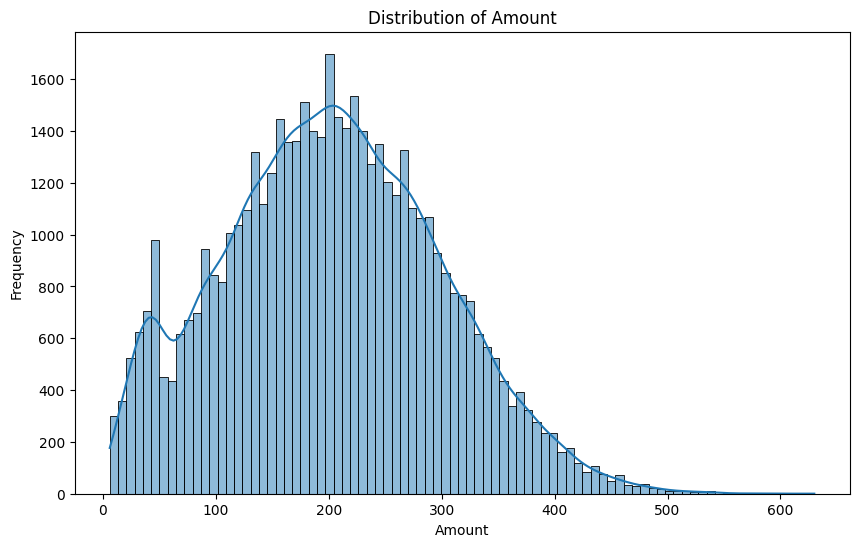

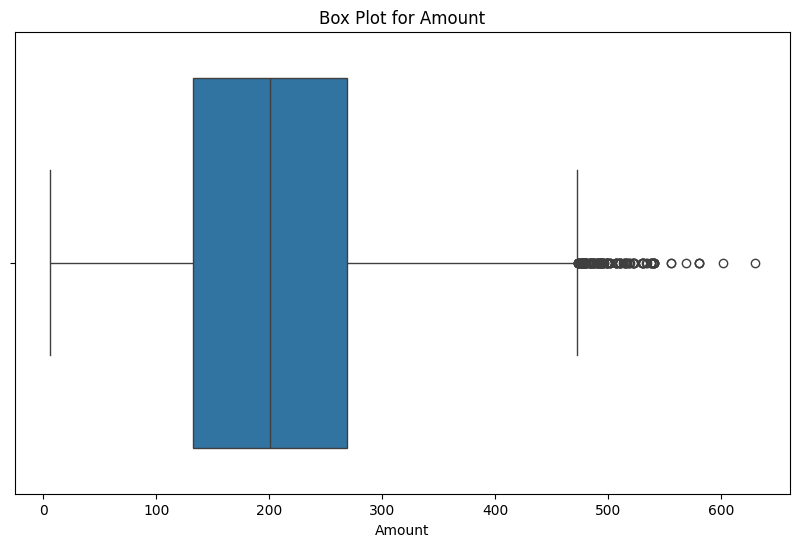

In [84]:
# Plotting the distribution of transaction amounts
plt.figure(figsize=(10, 6))
sns.histplot(df0['amount'], kde=True)  # Kernel Density Estimate (KDE) is added for smooth distribution
plt.title('Distribution of Amount')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.show()

# Identifying outliers in the 'amount' data using a box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x=df0['amount'])
plt.title('Box Plot for Amount')
plt.xlabel('Amount')
plt.show()


Perform D'Agostino's K-squared test to assess the normality of the transaction amounts. This statistical test helps determine if the amount data follows a normal distribution, which is crucial for certain types of statistical analysis and modeling.


In [85]:
# Perform D'Agostino's K-squared test to check the distribution of the 'amount' data
k2, dagostino_p_value = stats.normaltest(df0['amount'])

# Print the test statistic and p-value
print(f"D'Agostino's K-squared Test Statistic: {k2}, P-Value: {dagostino_p_value}")

# Determine if the data follows a normal distribution based on the p-value
if dagostino_p_value > 0.05:
    print("The data is normally distributed (fail to reject H0)")
else:
    print("The data is not normally distributed (reject H0)")


D'Agostino's K-squared Test Statistic: 640.8829086776663, P-Value: 6.8240878264269415e-140
The data is not normally distributed (reject H0)


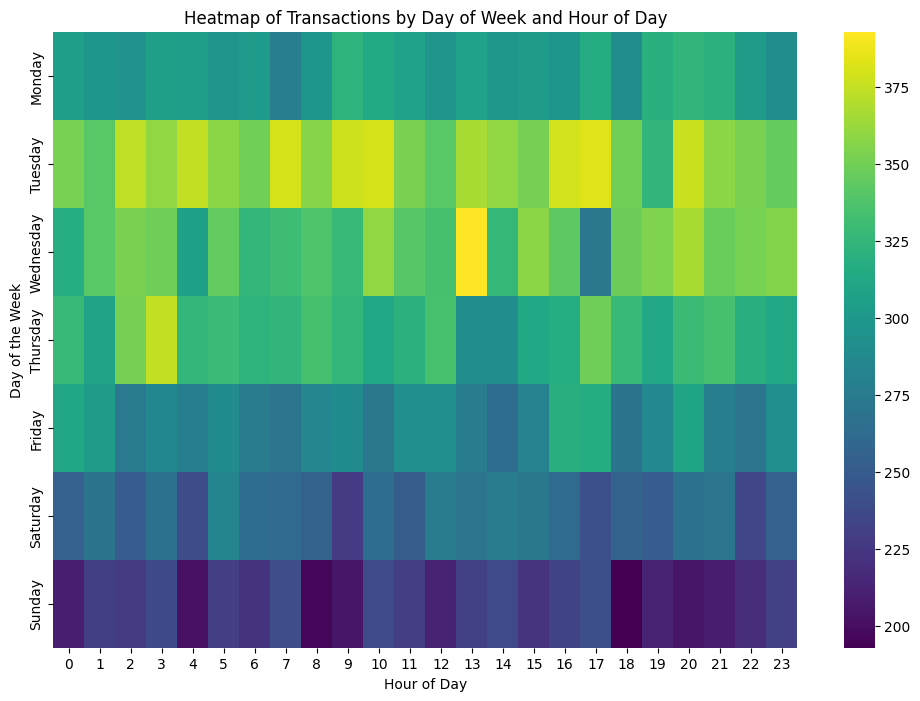

In [86]:
# Extracting day of the week and hour from the timestamp
df0['weekday'] = df0['tmsp'].dt.day_name()
df0['hour'] = df0['tmsp'].dt.hour

# Setting a specific order for the days of the week to ensure the heatmap follows a logical sequence
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df0['weekday'] = pd.Categorical(df0['weekday'], categories=days, ordered=True)

# Creating a pivot table to summarize transaction counts by hour and day of the week
heatmap_data = df0.pivot_table(index='weekday', columns='hour', values='tmsp', aggfunc='count', observed=False)

# Visualizing the data using a heatmap to better understand transaction patterns across the week
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='viridis', annot=False) # Set 'annot=True' to display the count numbers in the cells
plt.title('Heatmap of Transactions by Day of Week and Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Day of the Week')
plt.show()


Visualize the distribution of transactions across different attributes such as country, PSP, 3D secure status, and card type using count plots. These visualizations help identify which categories are most prevalent in the dataset.


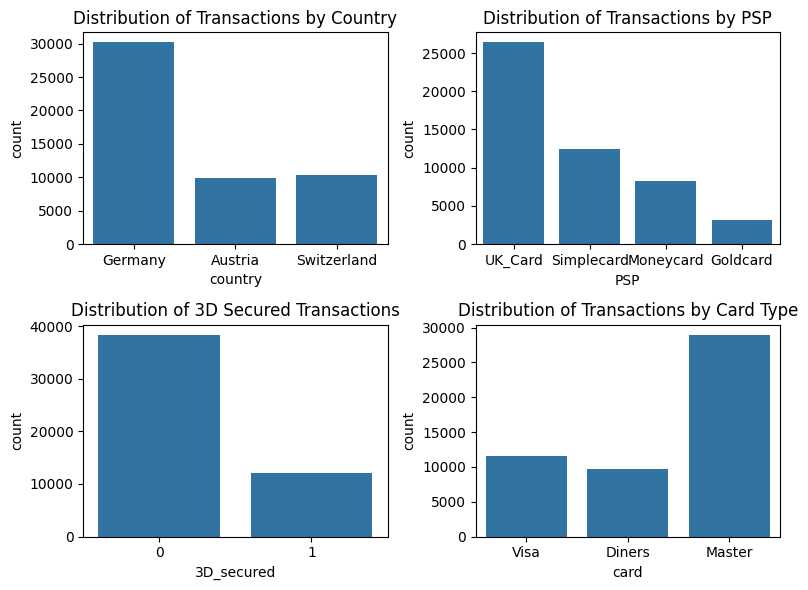

In [87]:
# Set up the matplotlib figure for Transaction Distributions
f, axes = plt.subplots(2, 2, figsize=(8, 6))

# Plot transaction distribution by Country
sns.countplot(x='country', data=df0, ax=axes[0, 0])
axes[0, 0].set_title('Distribution of Transactions by Country')

# Plot transaction distribution by PSP
sns.countplot(x='PSP', data=df0, ax=axes[0, 1])
axes[0, 1].set_title('Distribution of Transactions by PSP')

# Plot transaction distribution by 3D Secure status
sns.countplot(x='3D_secured', data=df0, ax=axes[1, 0])
axes[1, 0].set_title('Distribution of 3D Secured Transactions')

# Plot transaction distribution by Card Type
sns.countplot(x='card', data=df0, ax=axes[1, 1])
axes[1, 1].set_title('Distribution of Transactions by Card Type')

plt.tight_layout()
plt.show()


Visualize the average rate of 3D secured transactions by PSP, country, and card type to analyze security features' prevalence across different transaction categories.

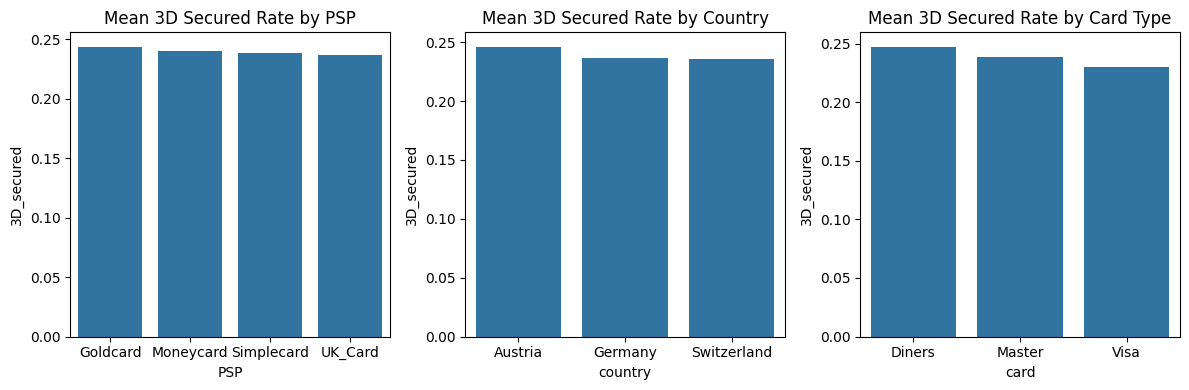

In [88]:
# Set up the matplotlib figure for 3D Secured Rates
f, axes = plt.subplots(1, 3, figsize=(12, 4))

# Plot mean 3D Secured rate by PSP
grouped = df0.groupby('PSP')['3D_secured'].mean().reset_index()
sns.barplot(x='PSP', y='3D_secured', data=grouped, ax=axes[0])
axes[0].set_title('Mean 3D Secured Rate by PSP')

# Plot mean 3D Secured rate by Country
grouped = df0.groupby('country')['3D_secured'].mean().reset_index()
sns.barplot(x='country', y='3D_secured', data=grouped, ax=axes[1])
axes[1].set_title('Mean 3D Secured Rate by Country')

# Plot mean 3D Secured rate by Card Type
grouped = df0.groupby('card')['3D_secured'].mean().reset_index()
sns.barplot(x='card', y='3D_secured', data=grouped, ax=axes[2])
axes[2].set_title('Mean 3D Secured Rate by Card Type')

plt.tight_layout()
plt.show()

Generate bar plots to show the mean success rate by different transaction attributes like PSP, 3D secure status, country, and card type. This helps in understanding which factors might influence the success rate of transactions.


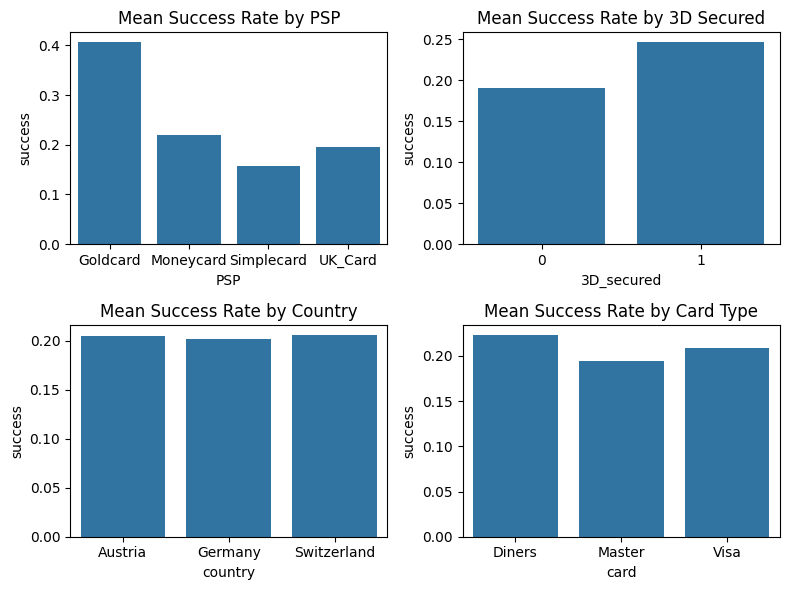

In [89]:
# Set up the matplotlib figure for Mean Success Rates
f, axes = plt.subplots(2, 2, figsize=(8, 6))

# Plot mean success rate by PSP
grouped = df0.groupby('PSP')['success'].mean().reset_index()
sns.barplot(x='PSP', y='success', data=grouped, ax=axes[0, 0])
axes[0, 0].set_title('Mean Success Rate by PSP')

# Plot mean success rate by 3D Secure status
grouped = df0.groupby('3D_secured')['success'].mean().reset_index()
sns.barplot(x='3D_secured', y='success', data=grouped, ax=axes[0, 1])
axes[0, 1].set_title('Mean Success Rate by 3D Secured')

# Plot mean success rate by Country
grouped = df0.groupby('country')['success'].mean().reset_index()
sns.barplot(x='country', y='success', data=grouped, ax=axes[1, 0])
axes[1, 0].set_title('Mean Success Rate by Country')

# Plot mean success rate by Card Type
grouped = df0.groupby('card')['success'].mean().reset_index()
sns.barplot(x='card', y='success', data=grouped, ax=axes[1, 1])
axes[1, 1].set_title('Mean Success Rate by Card Type')

plt.tight_layout()
plt.show()

Explore the relationship between transaction amounts and success rates for each payment service provider (PSP). This analysis segments the data by PSP and bins transaction amounts into quantiles ranging from 2 to 7. The Pearson correlation coefficient between these bins and the success status of transactions is calculated to identify any potential linear associations.


In [90]:
tempdf = df0.loc[df0['PSP'] == 'Goldcard'].copy()
tempdf.loc[:, 'amount_bin'] = pd.qcut(tempdf['amount'], q=8, labels=list(range(1, 8 + 1)))


In [91]:
# Iterate through each unique PSP in the DataFrame
for p in df0['PSP'].unique():
    print(p)  # Print the PSP being analyzed
    # Create a temporary DataFrame for the current PSP
    tempdf = df0.loc[df0['PSP'] == p].copy()
    # Loop to create quantile bins from 2 to 7 for the 'amount' feature
    for i in range(2, 8):
        # Categorize 'amount' into quantile bins, using .loc to modify the DataFrame in place
        tempdf['amount_bin'] = pd.qcut(tempdf['amount'], q=i, labels=list(range(1, i + 1)))
        # Calculate the Pearson correlation between 'amount_bin' and 'success'
        binCor = tempdf['amount_bin'].corr(tempdf['success'], method='pearson')
        print(f'bins: {i}, success Correlation: {binCor}')
    print('')


UK_Card
bins: 2, success Correlation: -0.18006197231005772
bins: 3, success Correlation: -0.15565773322117313
bins: 4, success Correlation: -0.16604694605665463
bins: 5, success Correlation: -0.15968799874582928
bins: 6, success Correlation: -0.1625607449328174
bins: 7, success Correlation: -0.15952498672295484

Simplecard
bins: 2, success Correlation: -0.018999571377576765
bins: 3, success Correlation: -0.018523253449028915
bins: 4, success Correlation: -0.025012448557033714
bins: 5, success Correlation: -0.021898362203625454
bins: 6, success Correlation: -0.022111700044488515
bins: 7, success Correlation: -0.02051507433176968

Moneycard
bins: 2, success Correlation: -0.011043701736442492
bins: 3, success Correlation: -0.016880305082400952
bins: 4, success Correlation: -0.019941505836279263
bins: 5, success Correlation: -0.01941884681297019
bins: 6, success Correlation: -0.023290588595352265
bins: 7, success Correlation: -0.023011906470170027

Goldcard
bins: 2, success Correlation: 0.

Use a simple decision tree to determine the threshold amount to split 'amount' for UK_Card PSP

In [92]:
# Prepare the data
X = df0[df0['PSP']=='UK_Card'][['amount']].values  # Feature matrix containing the transaction amounts of PSP UK_Card
y = df0[df0['PSP']=='UK_Card']['success'].values  # Target array containing success (1) or failure (0)

# Train a simple decision tree classifier
tree = DecisionTreeClassifier(max_depth=1)  # Limited depth to ensure we get broad splits
tree.fit(X, y)

# Visualize the decision tree to find the threshold
tree_rules = export_text(tree, feature_names=['amount'])
print(tree_rules)

|--- amount <= 199.50
|   |--- class: 0
|--- amount >  199.50
|   |--- class: 0



Perform Chi-squared tests for independence between 'success' and a set of categorical variables including 'weekday', 'hour', 'PSP', 'country', 'card', and '3D_secured'. This statistical test is used to determine whether there is a significant association between the success of transactions and these categorical factors. The results will help identify which categorical features significantly impact transaction success.


In [93]:
# List of categorical variables you want to test
categorical_vars = ['weekday', 'hour', 'PSP', 'country', 'card', '3D_secured']  # Add or remove variables as needed

alpha = 0.05  # Common threshold for significance

for var in categorical_vars:
    # Create a contingency table for each categorical variable with 'success'
    contingency_table = pd.crosstab(df0[var], df0['success'])
    
    # Perform the Chi-squared test
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    
    # Print the results
    print(f"For variable '{var}':")
    print(f"Chi-square statistic: {chi2}")
    print(f"P-value: {p}")
    
    # Interpretation based on the p-value
    if p < alpha:
        print(f"There is a significant difference in success rates across different {var}.")
    else:
        print(f"There is no significant difference in success rates across different {var}.")
    print("\n")  # Add a newline for better readability between outputs


For variable 'weekday':
Chi-square statistic: 51.7857055830811
P-value: 2.05930534753471e-09
There is a significant difference in success rates across different weekday.


For variable 'hour':
Chi-square statistic: 93.41473449174764
P-value: 1.8863087096327925e-10
There is a significant difference in success rates across different hour.


For variable 'PSP':
Chi-square statistic: 995.5290464487556
P-value: 1.6788693300545198e-215
There is a significant difference in success rates across different PSP.


For variable 'country':
Chi-square statistic: 1.1199024687309147
P-value: 0.5712369199004734
There is no significant difference in success rates across different country.


For variable 'card':
Chi-square statistic: 40.74558913329223
P-value: 1.4197364705921783e-09
There is a significant difference in success rates across different card.


For variable '3D_secured':
Chi-square statistic: 176.55057295639702
P-value: 2.7454257302058132e-40
There is a significant difference in success rate

Define and apply a function `identify_groups` to organize transactions into groups based on the transaction timestamp (`tmsp`), country, and amount. Transactions are grouped by calculating the time difference between consecutive transactions, and any gap of 60 seconds or more initiates a new group. This grouping helps in identifying sequences of transactions that are closely related in time and might represent repeated attempts or linked operations.

After identifying groups, create unique identifiers for each group and calculate the size of each group and the rank of each transaction within its group. Additionally, determine if consecutive transactions within the same group use the same PSP, indicating a repeated payment method for closely timed transactions.


In [94]:
def identify_groups(sub_df):
    # Calculate time difference within each sub-group
    sub_df['timedif'] = sub_df['tmsp'].diff().dt.total_seconds()
    
    # Identify rows that start a new group based on time difference
    sub_df['new_group_start'] = (sub_df['timedif'] >= 60) | sub_df['timedif'].isnull()
    
    # Generate group identifiers
    sub_df['temp_group'] = sub_df['new_group_start'].cumsum()
    
    return sub_df

# Apply the function to group transactions by country and amount
df0 = df0.groupby(['country', 'amount']).apply(identify_groups).reset_index(drop=True).sort_values(by='tmsp').reset_index(drop=True)

# Create a unique identifier for each group combining country, amount, and temp_group identifier
df0['group'] = df0['country'].astype(str) + '_' + df0['amount'].astype(str) + '_' + df0['temp_group'].astype(str)
# Factorize to ensure each group has a unique integer identifier
df0['group'] = pd.factorize(df0['group'])[0] + 1

# Calculate the size of each group
df0.loc[:, 'groupsize'] = df0.groupby('group')['group'].transform('size')

# Determine the rank of each transaction within its group
df0['group_rank'] = df0.groupby('group').cumcount() + 1

# Check if consecutive transactions in the same group are using the same PSP
df0['same_psp_in_group'] = (df0['PSP'] == df0['PSP'].shift()) & (df0['group'] == df0['group'].shift())

# Drop temporary columns used for calculations
df0.drop(['timedif', 'new_group_start', 'temp_group'], axis=1, inplace=True)


C:\Users\wille\AppData\Local\Temp\ipykernel_12684\262833040.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df0 = df0.groupby(['country', 'amount']).apply(identify_groups).reset_index(drop=True).sort_values(by='tmsp').reset_index(drop=True)


### Transaction Group Analysis

This section of the notebook focuses on analyzing the transaction groups. These groups represent collections of transactions that are likely linked (e.g., multiple payment attempts for a single purchase). The analysis provides the following insights:

1. **Total Unique Groups:** The total number of distinct transaction groups.
2. **Group Size Metrics:** Statistical figures such as the average and maximum sizes of these groups.
3. **Single Transaction Successes:** The count of successful transactions that are the only transaction within their group.
4. **PSP Diversity in Groups:** Understanding the variety of Payment Service Providers (PSPs) involved within groups, including the maximum and average number of PSPs per group.



In [95]:
# Calculate the total number of unique transaction groups
total_unique_groups = df0['group'].nunique()
print(f'Total unique groups: {total_unique_groups}')

# Calculate the average size of the groups
average_group_size = df0['groupsize'].mean()
print(f'Average group size: {average_group_size}')

# Find the maximum size of any group
max_group_size = df0['groupsize'].max()
print(f'Maximum group size: {max_group_size}')

# Count the number of successful transactions that occurred in groups of size one
single_transaction_successes = df0[(df0['groupsize'] == 1) & (df0['success'] == 1)].shape[0]
print(f'Number of successful single transactions: {single_transaction_successes}')

# Find the maximum number of different PSPs used within any single group
max_psp_per_group = df0.groupby('group')['PSP'].nunique().max()
print(f'Maximum PSPs per group: {max_psp_per_group}')

# Calculate the average number of different PSPs used across all groups
average_psp_per_group = df0.groupby('group')['PSP'].nunique().mean()
print(f'Average PSPs per group: {average_psp_per_group}')


Total unique groups: 27613
Average group size: 2.6733493612032824
Maximum group size: 10
Number of successful single transactions: 5690
Maximum PSPs per group: 4
Average PSPs per group: 1.3841668779198204


### Transaction Costs Calculation

This section of the code is dedicated to calculating and analyzing the financial implications of transaction success and failure across different PSPs (Payment Service Providers). The fees for successful and failed transactions are predefined for each PSP as follows:

- **Successful Transactions Fees:**
  - Moneycard: 5 Euro
  - Goldcard: 10 Euro
  - UK_Card: 3 Euro
  - Simplecard: 1 Euro

- **Failed Transactions Fees:**
  - Moneycard: 2 Euro
  - Goldcard: 5 Euro
  - UK_Card: 1 Euro
  - Simplecard: 0.5 Euro

The script performs the following calculations:
1. **Total Cost of Failed Transactions:** Calculates the sum of all fees for transactions that failed.
2. **Total Cost of Successful Transactions:** Summarizes the fees for all successful transactions.
3. **Average Transaction Cost per PSP:** Determines the average cost per transaction for each PSP, which includes both successful and failed transaction fees.
4. **Average Cost of a Successful Transaction:** For groups with at least one successful transaction, this computes the average cost, considering any accompanying failed transactions. Failed transactions without a successful counterpart are not included in this average.
5. **Total Cost of Transactions in Failed Groups:** Summarizes the costs for groups where no transactions were successful.


In [96]:
# Define fees for successful and failed transactions
fees_success = {
    'Moneycard': 5,   # fee for successful transactions in Euro
    'Goldcard': 10,
    'UK_Card': 3,
    'Simplecard': 1
}

fees_failed = {
    'Moneycard': 2,   # fee for failed transactions in Euro
    'Goldcard': 5,
    'UK_Card': 1,
    'Simplecard': 0.5
}


df0['transaction_cost']  = df0.apply(lambda x: fees_success[x['PSP']] if x['success']==1 else (fees_failed[x['PSP']]), axis=1)


# Calculate the total cost of failed transactions
total_cost_failed_transactions = df0[df0['success']==0]['transaction_cost'].sum()
print(f'Total cost of failed transactions: {total_cost_failed_transactions:.2f} Euro')

# Calculate the total cost of successful transactions
total_cost_successful_transactions = df0[df0['success']==1]['transaction_cost'].sum()
print(f'Total cost of successful transactions: {total_cost_successful_transactions:.2f} Euro')

# Calculate average cost per transaction per PSP
costs_per_psp = df0.groupby('PSP')['transaction_cost'].mean()
print('\nAverage transaction cost per PSP:')
print(costs_per_psp)

# Calculate average cost per successful transaction, this is for each successful transaction, the average cost including the accompanying failed transactions. 
# failed transactions that have no matching successful transaction are not included
successful_groups = df0[df0['success']==1]['group'].unique()
average_successul_transaction_cost = df0[df0['group'].isin(successful_groups)].groupby('group')['transaction_cost'].sum().mean()
print(f'\nAverage cost of successful transaction: {average_successul_transaction_cost:.2f} Euro')

# Calculate total cost of transactions that never reached a successful transaction
total_cost_failed_groups = df0[~df0['group'].isin(successful_groups)]['transaction_cost'].sum()
print(f'\nTotal cost of failed groups: {total_cost_failed_groups:.2f} Euro')


Total cost of failed transactions: 48964.50 Euro
Total cost of successful transactions: 39499.00 Euro

Average transaction cost per PSP:
PSP
Goldcard      7.030860
Moneycard     2.656499
Simplecard    0.579106
UK_Card       1.389723
Name: transaction_cost, dtype: float64

Average cost of successful transaction: 4.89 Euro

Total cost of failed groups: 38488.00 Euro


Define new categorical features based on existing temporal data to enhance the analysis:
1. **Part of Day**: Categorize each transaction into one of four time periods ('Night', 'Morning', 'Afternoon', 'Evening') based on the hour of the day. This categorization can help reveal trends in transaction activity throughout the day.
2. **Weekend Indicator**: Create a binary indicator ('is_weekend') to identify transactions that occur on weekends (Saturday or Sunday). This feature can be useful for analyses that compare weekend and weekday transaction behaviors, which might differ due to changes in consumer activity patterns.


In [97]:
# Categorize 'hour' into parts of the day
df0['part_of_day'] = pd.cut(df0['hour'], 
                            bins=[0, 6, 12, 18, 24], 
                            labels=['Night', 'Morning', 'Afternoon', 'Evening'],
                            right=False)

# Determine if the transaction occurred on a weekend
df0['is_weekend'] = df0['weekday'].apply(lambda x: 1 if x in ['Sunday', 'Saturday'] else 0)


Introduce enriched features to the dataset to provide deeper insights into transaction patterns:
1. **Historical Success Rate**: Calculate the average success rate for each combination of Payment Service Provider (PSP) and card type. This metric will allow us to understand the historical performance of each combination, potentially influencing predictive models.
2. **Transaction Counts**: Count the number of transactions for each combination of PSP and card type. This count gives an idea of the popularity or frequency of use for each combination, which can be a useful feature for modeling and analysis, indicating the reliability or preference among consumers.

These features are integrated back into the original DataFrame to maintain a comprehensive dataset ready for advanced analysis or modeling.


In [98]:
# Calculate historical success rates for each PSP and card type combination
historical_success_rate = df0.groupby(['PSP', 'card'])['success'].mean().reset_index(name='historical_success_rate')

# Merge the calculated historical success rates back into the main DataFrame
df0 = df0.merge(historical_success_rate, on=['PSP', 'card'], how='left')

# Calculate the count of transactions for each PSP and card type combination
transaction_counts = df0.groupby(['PSP', 'card']).size().reset_index(name='transaction_count')

# Merge the transaction counts back into the main DataFrame
df0 = df0.merge(transaction_counts, on=['PSP', 'card'], how='left')


Implement frequency encoding for the 'PSP' column to convert categorical data into a format that can be used more effectively in machine learning models:
- **Frequency Encoding**: This technique transforms the categorical variable 'PSP' by replacing each category with the count of occurrences in the dataset. This encoding helps capture the prevalence of each PSP within the data, which might reflect its popularity or trustworthiness and could be a useful predictor in models.

This new feature, 'PSP_freq_enc', is added to the dataset to provide a numerical representation of the categorical 'PSP' data based on its frequency.


In [99]:
# Create a frequency encoding for the 'PSP' column based on the number of occurrences of each PSP
frequency_encoding = df0['PSP'].value_counts().to_dict()

# Apply the frequency encoding to create a new column in the DataFrame
df0['PSP_freq_enc'] = df0['PSP'].map(frequency_encoding)


Bin the transaction 'amount' into quantiles to capture the relative size of each transaction:
- **Quantile Binning**: Segment the 'amount' data into four quantiles and label them from 1 to 4, representing increasing transaction amounts. This process converts a continuous variable into an ordinal categorical variable, which can be useful for non-linear model training and provides a simplified view of transaction sizes.

The new feature, 'amount_bin', categorizes each transaction into one of four bins based on its amount, facilitating analyses that compare behaviors across different transaction sizes.


In [100]:
# Bin the 'amount' into 4 quantiles and label them as 1, 2, 3, 4
df0['amount_bin'] = pd.qcut(df0['amount'], q=4, labels=[1, 2, 3, 4]).astype('int')


Finalize the DataFrame preparation for machine learning modeling by performing the following steps:
- **Drop Unnecessary Columns**: Remove columns that are not needed for modeling, such as 'group', 'groupsize', 'tmsp', and 'weekday'.
- **Scale Numeric Data**: Apply Min-Max scaling to the 'amount' feature to normalize its values between 0 and 1, making the data suitable for algorithms sensitive to the scale of input features.
- **Encode Categorical Data**: Convert categorical variables such as 'is_weekend' and 'part_of_day' into numeric format using label encoding to make them usable in machine learning models.
- **One-Hot Encoding**: Apply one-hot encoding to the remaining categorical features to convert them into a binary vector representation, which is ideal for handling nominal categorical data without imposing ordinality.

These transformations ensure that the dataset's features are appropriately formatted and scaled for optimal performance in subsequent modeling.


In [101]:
# Drop unnecessary columns from the DataFrame
df0.drop(columns=['group', 'groupsize', 'tmsp', 'weekday', 'transaction_cost'], axis=1, inplace=True)

# Scale the 'amount' feature using Min-Max scaling
min_max_scaler = MinMaxScaler(feature_range=(0, 1))
df0['amount'] = min_max_scaler.fit_transform(df0['amount'].values.reshape(-1, 1))

# Encode binary and categorical variables
le = LabelEncoder()
df0['is_weekend'] = le.fit_transform(df0['is_weekend'])
df0['part_of_day'] = le.fit_transform(df0['part_of_day'])

# Apply one-hot encoding to object and category dtype columns
df0 = pd.get_dummies(df0, columns=df0.select_dtypes(include=['object', 'category']).columns, drop_first=False)


Prepare the dataset for machine learning by splitting the features and the target variable, and then divide the data into training and testing sets:
- **Feature and Target Separation**: Isolate the 'success' column as the target variable (`y`) and the rest of the DataFrame as the feature set (`X`).
- **Data Splitting**: Use the `train_test_split` function to randomly split the data into training and testing subsets. This split helps in evaluating the model's performance on unseen data, ensuring the model's generalizability.

A standard practice is to allocate 80% of the data for training and 20% for testing, with a fixed random state to ensure reproducibility of the results.


In [102]:
# Separate the features and the target variable
X = df0.drop('success', axis=1)  # Features
y = df0['success']  # Target variable

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Address the class imbalance issue in the dataset by downsampling the majority class:
- **Concatenate Features and Target**: Rejoin the training features and target variable into a single DataFrame for easier manipulation of class subsets.
- **Class Separation**: Identify and separate the majority class (success=0) and the minority class (success=1) into different DataFrames to handle them individually.
- **Majority Class Downsampling**: Randomly downsample the majority class to match the size of the minority class, ensuring that each class has an equal representation in the training data. This helps prevent model bias towards the majority class.
- **Combine Classes**: After downsampling, concatenate the downsampled majority class and the original minority class to form a balanced training dataset.

This process ensures that the training data does not favor the majority class, which can improve model performance, especially in metrics such as precision, recall, and F1-score.


In [103]:
# Concatenate features and target for the training data to facilitate class balancing
df1 = pd.concat([X_train, y_train], axis=1)

# Separate the data into majority and minority classes based on the target
df_majority = df1[df1['success'] == 0]
df_minority = df1[df1['success'] == 1]

# Downsample the majority class to the size of the minority class
df_majority_downsampled = resample(df_majority, 
                                   replace=False,    # Sample without replacement
                                   n_samples=len(df_minority),     # Match minority class size
                                   random_state=42) # Ensure reproducibility

# Combine the downsampled majority class with the minority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])

# Separate features and target variable for the balanced training data
X_train = df_downsampled.drop('success', axis=1)
y_train = df_downsampled['success']


Calculate the success rates based on specific features and then predict success probabilities using these rates as a simple base model:
- **Compute Success Rates**: For selected features including security measures, payment service providers (PSP), and card types, calculate the mean success rate for each category within these features. This computation is done using the balanced training dataset.
- **Store Success Rates**: Save these calculated success rates in a dictionary for easy lookup, keyed by feature name for organized access.
- **Predictive Model Simulation**: Develop a function to compute a weighted average success rate for each transaction based on the applicable success rates for its features. This simple model essentially averages the relevant success probabilities for each transaction based on its attribute values.
- **Model Application**: Apply this function to the test dataset to simulate predictions and calculate probabilities, which serve as a simple baseline model output for comparing more complex machine learning models.

This approach provides a baseline understanding of the transaction success likelihood, based on historical success rates associated with specific categorical attributes of the transactions.


In [104]:
# Dictionary to store success rates for each relevant feature
success_rates = {}

# Iterate through selected feature columns and calculate success rates
for column in ['3D_secured', 'PSP_Goldcard', 'PSP_Moneycard', 'PSP_Simplecard', 'PSP_UK_Card',
               'card_Diners', 'card_Master', 'card_Visa', 'amount_bin']:
    # Calculate and store the mean success rates per category within each column
    success_rate_dict = df_downsampled.groupby([column])['success'].mean().to_dict()
    success_rates[column] = success_rate_dict

# Function to calculate weighted average success rate for each row in the DataFrame
def calculate_base_model_success_rate(row):
    weighted_sum = sum(success_rates[col][row[col]] for col in success_rates if col in row)
    return weighted_sum / len(success_rates)

# Apply the function to predict success rates on the test dataset
baseModelPredicts = round(X_test.apply(calculate_base_model_success_rate, axis=1))
baseModelProba = X_test.apply(calculate_base_model_success_rate, axis=1)


Define a function `evaluate_model` to assess the performance of the prediction model on the test data using several metrics. The function will compute the following:
- **Accuracy**: Measures the proportion of true results (both true positives and true negatives) among the total number of cases examined.
- **Precision**: The ratio of correctly predicted positive observations to the total predicted positives, indicating the quality of positive predictions.
- **Recall**: The ratio of correctly predicted positive observations to all actual positives, showing the ability of the model to find all relevant cases.
- **F1 Score**: The weighted average of Precision and Recall, providing a balance between Precision and Recall in one number.
- **ROC AUC**: The area under the Receiver Operating Characteristic curve, a graphical representation of the diagnostic ability of a binary classifier system.

This function prints the performance metrics for a given set of predictions and their corresponding true values, facilitating the evaluation of model effectiveness.

Then, apply this function to evaluate the basic model that uses weighted historical success rates to predict transaction success on the test data.


In [105]:
# Define a function to evaluate various performance metrics of the model
def evaluate_model(y_true, y_preds, y_probs):
    accuracy = accuracy_score(y_true, y_preds)  # Calculate accuracy
    precision = precision_score(y_true, y_preds)  # Calculate precision
    recall = recall_score(y_true, y_preds)  # Calculate recall
    f1 = f1_score(y_true, y_preds)  # Calculate F1 score
    roc_auc = roc_auc_score(y_true, y_probs)  # Calculate ROC AUC score
    
    # Print all calculated metrics
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'ROC AUC: {roc_auc:.4f}')

# Evaluate the base model using the defined function
print("Base Model:")
evaluate_model(y_test, baseModelPredicts, baseModelProba)


Base Model:
Accuracy: 0.6047
Precision: 0.2734
Recall: 0.5502
F1 Score: 0.3653
ROC AUC: 0.6123


Train a suite of decision tree-based classifiers on the balanced training dataset to predict the success of transactions. Each model employs different strategies or variations of ensemble methods to optimize prediction accuracy:
1. **Decision Tree Classifier**: A base decision tree model that uses class weights to address the imbalance in the dataset.
2. **Random Forest Classifier**: An ensemble model consisting of multiple decision trees to reduce the risk of overfitting while also handling class imbalance with balanced class weights.
3. **Gradient Boosting Classifier**: Uses boosting techniques to create a strong predictive model by sequentially correcting errors of weak classifiers through the addition of new models.
4. **AdaBoost Classifier**: Another boosting model that focuses on increasing the weight of misclassified instances in successive trees to improve classification accuracy.
5. **XGBoost Classifier**: An implementation of gradient boosted decision trees designed for speed and performance that typically yields efficient and effective results.

This combination of models provides a broad comparison of techniques, from single trees to advanced boosting methods, ensuring a thorough exploration of methods to address the classification challenge.


In [106]:
# Initialize and fit a Decision Tree classifier with balanced class weights
dt = DecisionTreeClassifier(random_state=42, class_weight='balanced')
dt.fit(X_train, y_train)

# Initialize and fit a Random Forest classifier with balanced class weights
rf = RandomForestClassifier(random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)

# Initialize and fit a Gradient Boosting classifier with default settings
gb_clf = GradientBoostingClassifier(random_state=42)
gb_clf.fit(X_train, y_train)

# Initialize and fit an AdaBoost classifier with default settings
ab_clf = AdaBoostClassifier(random_state=42)
ab_clf.fit(X_train, y_train)

# Initialize and fit an XGBoost classifier with default settings
xgb_clf = XGBClassifier(random_state=42)
xgb_clf.fit(X_train, y_train)


C:\Users\wille\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

After training the models, proceed to generate predictions and their corresponding probabilities for the test dataset. This step is to evaluate how each model performs on unseen data:

These predictions and probabilities are used for comparing the effectiveness of each model, particularly in terms of how well they generalize from the training data to the test data, a key factor in model selection.


In [107]:
# Generate predictions and probabilities for the Random Forest model
rf_preds = rf.predict(X_test)
rf_probs = rf.predict_proba(X_test)[:, 1]

# Generate predictions and probabilities for the Decision Tree model
dt_preds = dt.predict(X_test)
dt_probs = dt.predict_proba(X_test)[:, 1]

# Generate predictions and probabilities for the Gradient Boosting model
gb_clf_preds = gb_clf.predict(X_test)
gb_clf_probs = gb_clf.predict_proba(X_test)[:, 1]

# Generate predictions and probabilities for the AdaBoost model
ab_clf_preds = ab_clf.predict(X_test)
ab_clf_probs = ab_clf.predict_proba(X_test)[:, 1]

# Generate predictions and probabilities for the XGBoost model
xgb_clf_preds = xgb_clf.predict(X_test)
xgb_clf_probs = xgb_clf.predict_proba(X_test)[:,1]


Evaluate the performance of each trained model on the test dataset using the predefined `evaluate_model` function. 

In [108]:
# Evaluate the performance of the Random Forest model
print("\nRandom Forest Performance:")
evaluate_model(y_test, rf_preds, rf_probs)

# Evaluate the performance of the Decision Tree model
print("\nDecision Tree Performance:")
evaluate_model(y_test, dt_preds, dt_probs)

# Evaluate the performance of the Gradient Boosting model
print("\nGradient Boost Performance:")
evaluate_model(y_test, gb_clf_preds, gb_clf_probs)

# Evaluate the performance of the AdaBoost model
print("\nAda Boost Performance:")
evaluate_model(y_test, ab_clf_preds, ab_clf_probs)

# Evaluate the performance of the XGBoost model
print("\nXGBoost Performance:")
evaluate_model(y_test, xgb_clf_preds, xgb_clf_probs)



Random Forest Performance:
Accuracy: 0.5769
Precision: 0.2600
Recall: 0.5670
F1 Score: 0.3565
ROC AUC: 0.5969

Decision Tree Performance:
Accuracy: 0.5445
Precision: 0.2342
Recall: 0.5300
F1 Score: 0.3248
ROC AUC: 0.5392

Gradient Boost Performance:
Accuracy: 0.5969
Precision: 0.2905
Recall: 0.6588
F1 Score: 0.4032
ROC AUC: 0.6557

Ada Boost Performance:
Accuracy: 0.6048
Precision: 0.2760
Recall: 0.5617
F1 Score: 0.3702
ROC AUC: 0.6268

XGBoost Performance:
Accuracy: 0.5965
Precision: 0.2818
Recall: 0.6146
F1 Score: 0.3864
ROC AUC: 0.6387


## Gradient Boosting and XGBoost Optimization

The setup outlined below configures two independent machine learning pipelines optimized through Bayesian search techniques:
- **Gradient Boosting**
- **XGBoost**

Both pipelines are tailored to identify the optimal set of hyperparameters that maximize the area under the ROC curve using a 5-fold cross-validation strategy. This methodological approach enhances the capacity to tune:
- Tree depth
- Learning rate
- Regularization parameters


In [109]:
# Define the steps of the pipeline with Gradient Boosting Classifier
estimators_gb = [
    ('gb_clf', GradientBoostingClassifier(random_state=42)),
]

# Create the pipeline
pipe_gb = Pipeline(steps=estimators_gb)

# Define the hyperparameter space for Bayesian optimization
search_space = {
    'gb_clf__max_depth': Integer(2, 15), 
    'gb_clf__learning_rate': Real(0.01, 1.0, prior='log-uniform'),
    'gb_clf__subsample': Real(0.6, 1.0), 
    'gb_clf__n_estimators': Integer(100, 500), 
    'gb_clf__min_samples_split': Integer(2, 10),
    'gb_clf__min_samples_leaf': Integer(1, 10), 
    'gb_clf__max_features': Categorical(['sqrt', 'log2', None]), 
    'gb_clf__loss': Categorical(['log_loss', 'exponential']),
}

# Configure and initialize BayesSearchCV
opt_gb = BayesSearchCV(pipe_gb, search_space, cv=5, n_iter=10, scoring='roc_auc', random_state=42)


# Define the steps of the pipeline with XG Boosting Classifier

estimators_xgb = [
    ('xgb_clf', XGBClassifier( tree_method='exact', booster='gbtree',random_state=42))
]

# Create the pipeline
pipe_xgb = Pipeline(steps=estimators_xgb)

# Define the hyperparameter space for Bayesian optimization
search_space = {
    'xgb_clf__max_depth': Integer(4,12),
    'xgb_clf__learning_rate': Real(0.001, 0.2, prior='log-uniform'),
    'xgb_clf__subsample': Real(0.5,1.0),
    'xgb_clf__min_child_weight': Integer(1, 6),
    'xgb_clf__colsample_bytree': Real(0.5,1.0),
    'xgb_clf__colsample_bylevel': Real(0.5,1.0),
    'xgb_clf__colsample_bynode': Real(0.5,1.0),
    'xgb_clf__reg_alpha': Real(0.0, 10.0),
    'xgb_clf__reg_lambda': Real(0.0, 10.0),
    'xgb_clf__gamma': Real(0.0, 1.0)
}


# Configure and initialize BayesSearchCV
opt_xgb = BayesSearchCV(pipe_xgb, search_space, cv=5, n_iter=10, scoring='roc_auc', random_state=42)

Execute the `fit` method of the `BayesSearchCV` object to train the GradientBoostingClassifier within the pipeline using Bayesian optimization over the predefined hyperparameter space. This step will iteratively explore different combinations of parameters to find those that maximize the area under the ROC curve (ROC AUC):

- **Model Training**: The fitting process will use cross-validation to assess the performance of different hyperparameter settings across multiple subsets of the dataset, thus ensuring that the optimization is robust and generalizable.
- **Bayesian Optimization**: This method uses a probabilistic model to predict the performance of different hyperparameter combinations and focuses subsequent searches on areas expected to yield improvements. This approach is particularly efficient in finding optimal solutions with fewer iterations compared to grid or random search.



In [110]:
# Fit the Gradient Boosting model using Bayesian optimization
opt_gb.fit(X_train, y_train)

# Fit the XGBoost model using Bayesian optimization
opt_xgb.fit(X_train, y_train)


BayesSearchCV(cv=5,
              estimator=Pipeline(steps=[('xgb_clf',
                                         XGBClassifier(base_score=None,
                                                       booster='gbtree',
                                                       callbacks=None,
                                                       colsample_bylevel=None,
                                                       colsample_bynode=None,
                                                       colsample_bytree=None,
                                                       device=None,
                                                       early_stopping_rounds=None,
                                                       enable_categorical=False,
                                                       eval_metric=None,
                                                       feature_types=None,
                                                       gamma=None,
                                                       grow_policy=None,
                                                       importance_type=None,
                                                       interaction_cons...
                             'xgb_clf__max_depth': Integer(low=4, high=12, prior='uniform', transform='normalize'),
                             'xgb_clf__min_child_weight': Integer(low=1, high=6, prior='uniform', transform='normalize'),
                             'xgb_clf__reg_alpha': Real(low=0.0, high=10.0, prior='uniform', transform='normalize'),
                             'xgb_clf__reg_lambda': Real(low=0.0, high=10.0, prior='uniform', transform='normalize'),
                             'xgb_clf__subsample': Real(low=0.5, high=1.0, prior='uniform', transform='normalize')})

Utilize the optimized GradientBoostingClassifier model from the `BayesSearchCV` to make predictions on the test dataset.

In [111]:
# Obtain class predictions and probability estimates from the optimized GradientBoostingClassifier
opt_gb_preds = opt_gb.predict(X_test)
opt_gb_probs = opt_gb.predict_proba(X_test)[:, 1]

# Evaluate the predictive performance using predefined evaluation metrics
print('Evaluation of optimized Gradient Boosting model:')
evaluate_model(y_test, opt_gb_preds, opt_gb_probs)

# Obtain class predictions and probability estimates from the optimized XGBoost Classifier
opt_xgb_preds = opt_xgb.predict(X_test)
opt_xgb_probs = opt_xgb.predict_proba(X_test)[:, 1]

# Evaluate the predictive performance using predefined evaluation metrics
print('\nEvaluation of optimized XGBoost model:')
evaluate_model(y_test, opt_xgb_preds, opt_xgb_probs)


Evaluation of optimized Gradient Boosting model:
Accuracy: 0.5980
Precision: 0.2878
Recall: 0.6406
F1 Score: 0.3971
ROC AUC: 0.6485

Evaluation of optimized XGBoost model:
Accuracy: 0.6012
Precision: 0.2961
Recall: 0.6747
F1 Score: 0.4116
ROC AUC: 0.6613


### Feature Importance of the Optimized XGBoost Model

Visualizing the feature importance provides insights into which features most significantly impact the model's predictions. Here, we use the 'gain' measure of importance, which represents the improvement in accuracy brought by a feature to the branches it is on. 


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

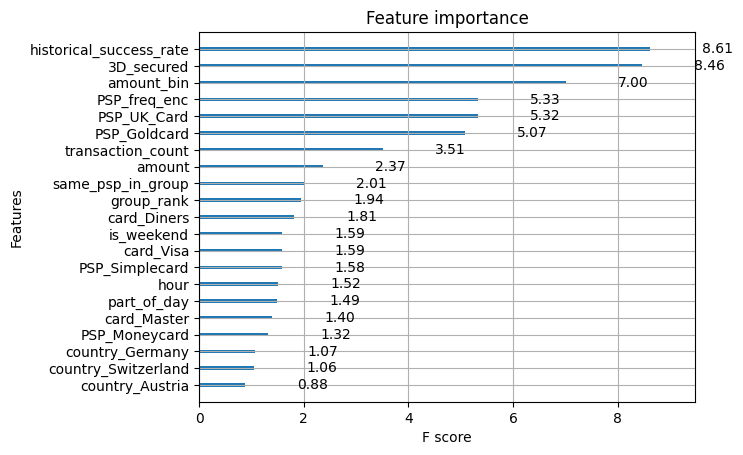

In [112]:
xgboost_model = opt_xgb.best_estimator_.steps[0][1]
plot_importance(xgboost_model, importance_type='gain', values_format='{v:.2f}')

In [232]:
# Retrieve feature importances using 'gain' which measures the average gain of splits which use the feature
feature_importance_gain = xgboost_model.get_booster().get_score(importance_type='gain')

# Display the feature importances
feature_importance_gain

{'amount': 2.370021104812622,
 '3D_secured': 8.46068286895752,
 'hour': 1.5159059762954712,
 'group_rank': 1.9410780668258667,
 'same_psp_in_group': 2.007796287536621,
 'part_of_day': 1.4880326986312866,
 'is_weekend': 1.592635154724121,
 'historical_success_rate': 8.613969802856445,
 'transaction_count': 3.5063576698303223,
 'PSP_freq_enc': 5.32967472076416,
 'amount_bin': 7.0035247802734375,
 'country_Austria': 0.8758012056350708,
 'country_Germany': 1.0687954425811768,
 'country_Switzerland': 1.056829810142517,
 'PSP_Goldcard': 5.072874069213867,
 'PSP_Moneycard': 1.3212934732437134,
 'PSP_Simplecard': 1.581961750984192,
 'PSP_UK_Card': 5.322088241577148,
 'card_Diners': 1.8120391368865967,
 'card_Master': 1.402453899383545,
 'card_Visa': 1.587186336517334}

### Confusion Matrix Analysis

The confusion matrix is a useful tool for understanding the performance of the classification model. It shows the number of correct and incorrect predictions made by the model compared to the actual classifications in the test data. The matrix is structured as follows:

- **True Negative (TN)**: The top-left value indicates the number of correctly predicted negative classifications.
- **False Positive (FP)**: The top-right value shows the number of incorrect predictions where the model predicted the positive class.
- **False Negative (FN)**: The bottom-left value represents the number of incorrect predictions where the model predicted the negative class.
- **True Positive (TP)**: The bottom-right value is the number of correctly predicted positive classifications.



In [139]:

# Calculate the confusion matrix for the test predictions
conf_matrix = confusion_matrix(y_test, opt_gb_preds)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)


Confusion Matrix:
[[4686 3299]
 [ 748 1333]]


### Error Analysis

To improve the performance of our predictive model, it's crucial to analyze the types of errors it makes. This involves identifying false positives and false negatives within the predictions:

- **False Positives (Type I Error):** Occur when the model incorrectly predicts the positive class. This type of error may lead to unnecessary actions or costs, depending on the application. For example, in medical testing, a false positive might result in unnecessary further testing or treatment.

- **False Negatives (Type II Error):** Occur when the model fails to predict the positive class. This type of error can be critical as it may result in missed opportunities for interventions. For example, in disease screening, a false negative could mean missing a disease diagnosis, potentially leading to serious health repercussions.

Understanding these errors helps us tailor our model improvements more effectively, focusing on reducing the most impactful types of errors based on the specific needs and consequences in the application context.


In [118]:
# predictions from the optimized gradient boosting model
predictions = opt_gb_preds

# Identify all incorrect predictions (errors)
errors = predictions != y_test

# Identify false positives: where the model incorrectly predicts the positive class
false_positives = (predictions == 1) & (y_test == 0)

# Identify false negatives: where the model incorrectly predicts the negative class
false_negatives = (predictions == 0) & (y_test == 1)

### Reversing Data Preprocessing for Test Set

In order to make sense of the predictions and perform qualitative analysis or error analysis, it's often helpful to revert preprocessed data back to its original form:

- **Amount Scaling Reversed:** The `amount` feature was scaled for modeling purposes using Min-Max scaling. Here, we reverse this scaling to analyze transactions in their original monetary values.
- **Categorical Variables Reconstructed:** Categorical variables `country`, `card`, and `PSP` were previously transformed into one-hot encoded formats for model training. Here, we reconstruct these categorical variables from their one-hot encoded formats back to their original categorical format. This step improves the interpretability of our analysis by replacing binary columns with their original nominal categories.


In [116]:
# Reverse Min-Max scaling for 'amount' to restore original values
X_test['amount'] = min_max_scaler.inverse_transform(X_test['amount'].values.reshape(-1, 1))

# Reverse one-hot encoding for 'country'
# Assuming the columns are named as 'country_Austria', 'country_Germany', 'country_Switzerland'
country_columns = ['country_Austria', 'country_Germany', 'country_Switzerland']
X_test['country'] = pd.DataFrame(X_test[country_columns], columns=country_columns).idxmax(axis=1).str.replace('country_', '')

# Reverse one-hot encoding for 'card'
# Assuming the columns are named as 'card_Diners', 'card_Visa', 'card_Master'
card_columns = ['card_Diners', 'card_Visa', 'card_Master']
X_test['card'] = pd.DataFrame(X_test[card_columns], columns=card_columns).idxmax(axis=1).str.replace('card_', '')

# Reverse one-hot encoding for 'PSP'
# Assuming the columns are named as 'PSP_UK_Card', 'PSP_Goldcard', 'PSP_Moneycard', 'PSP_Simplecard'
psp_columns = ['PSP_UK_Card', 'PSP_Goldcard', 'PSP_Moneycard', 'PSP_Simplecard']
X_test['PSP'] = pd.DataFrame(X_test[psp_columns], columns=psp_columns).idxmax(axis=1).str.replace('PSP_', '')



### Analysis of Transaction Amounts and Prediction Errors

The following visualizations provide a detailed analysis of the distribution of transaction amounts relative to the prediction outcomes from our model:

1. **Amount: Correct vs. Incorrect Predictions**
   - This histogram compares the distribution of transaction amounts for correct predictions against incorrect predictions. It helps in identifying how well the model performs across different transaction values.

2. **Amount: False Positives vs. False Negatives**
   - Focuses on incorrectly predicted transactions, showing the amount distribution for false positives and false negatives. This aids in understanding which transactions are more likely to be misclassified.

3. **Amount Bin: Correct vs. Incorrect Predictions**
   - Similar to the first histogram but uses binned transaction amounts. This categorization simplifies the view, making it easier to spot trends across different transaction size categories.

4. **Amount Bin: False Positives vs. False Negatives**
   - Provides a comparative view of binned amounts for transactions that were incorrectly predicted as successful (false positives) or unsuccessful (false negatives). 

These plots are essential for identifying specific areas where the predictive model may need improvement, particularly in handling transactions of different sizes.


In [235]:
print('errors')
print(X_test[errors]['amount'].describe())
print('\ncorrect')
print(X_test[~errors]['amount'].describe())


errors
count    4047.000000
mean      175.158636
std        94.147619
min         6.000000
25%       103.500000
50%       168.000000
75%       238.000000
max       517.000000
Name: amount, dtype: float64

correct
count    6019.000000
mean      217.858448
std        94.086975
min         6.000000
25%       154.000000
50%       219.000000
75%       279.000000
max       538.000000
Name: amount, dtype: float64


In [236]:
print('fn')
print(X_test[false_negatives]['amount'].describe())
print('\fp')
print(X_test[false_positives]['amount'].describe())

fn
count    748.000000
mean     219.167112
std       90.278374
min        7.000000
25%      163.000000
50%      224.000000
75%      279.250000
max      450.000000
Name: amount, dtype: float64
p
count    3299.000000
mean      165.180358
std        92.137029
min         6.000000
25%        97.000000
50%       158.000000
75%       219.000000
max       517.000000
Name: amount, dtype: float64


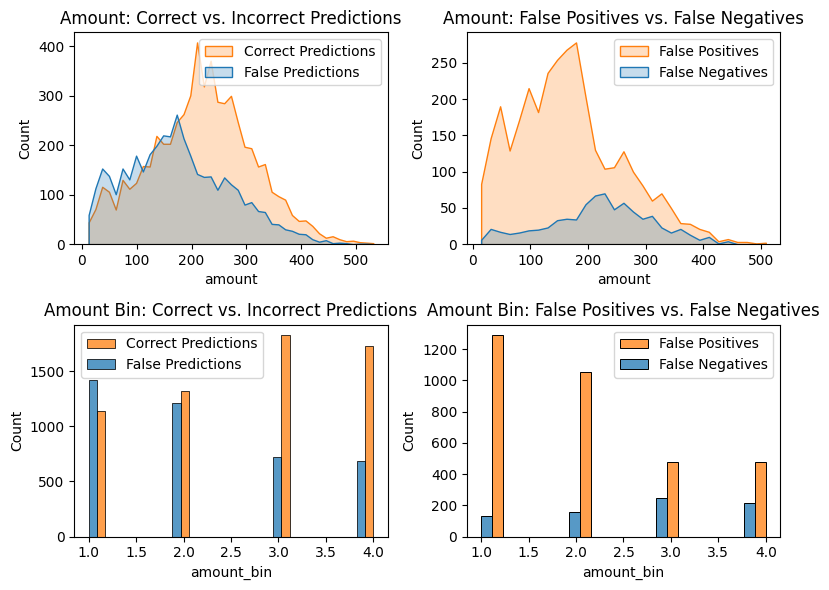

In [224]:
# Set up a 2x2 subplot layout with a figure size of 8x6 inches
f, axes = plt.subplots(2, 2, figsize=(8, 6))

# Plot histogram of 'amount' comparing correct and incorrect predictions
sns.histplot(data=X_test, x='amount', hue=~errors, multiple="layer", element='poly', ax=axes[0, 0])
axes[0, 0].legend(labels=['Correct Predictions', 'False Predictions'])
axes[0, 0].set_title('Amount: Correct vs. Incorrect Predictions')

# Plot histogram of 'amount' for errors only, differentiating between false positives and false negatives
sns.histplot(data=X_test[errors], x='amount', hue=false_positives, multiple="layer", element='poly', ax=axes[0, 1])
axes[0, 1].set_title('Amount: False Positives vs. False Negatives')
axes[0, 1].legend(labels=['False Positives', 'False Negatives'])

# Plot histogram of 'amount_bin' comparing correct and incorrect predictions
sns.histplot(data=X_test, x='amount_bin', hue=~errors, multiple="dodge", ax=axes[1, 0])
axes[1, 0].set_title('Amount Bin: Correct vs. Incorrect Predictions')
axes[1, 0].legend(labels=['Correct Predictions', 'False Predictions'])

# Plot histogram of 'amount_bin' for errors only, differentiating between false positives and false negatives
sns.histplot(data=X_test[errors], x='amount_bin', hue=false_positives, multiple="dodge", ax=axes[1, 1])
axes[1, 1].set_title('Amount Bin: False Positives vs. False Negatives')
axes[1, 1].legend(labels=['False Positives', 'False Negatives'])

# Adjust the layout to avoid overlap
plt.tight_layout()
plt.show()


### Visual Analysis of Prediction Accuracy by Card Type and PSP

This section provides a detailed examination of the model's prediction performance across different card types and payment service providers (PSPs), segmented by their error types:

1. **Card Type: Correct vs Incorrect Predictions**
   - This visualization compares the frequency of correct and incorrect predictions across different card types. It helps identify which card types are more prone to prediction errors, guiding potential model improvements.

2. **Card Type: False Positives vs False Negatives**
   - This plot focuses on the incorrect predictions for different card types, distinguishing between false positives (transactions incorrectly predicted as successful) and false negatives (transactions incorrectly predicted as failed).

3. **PSP: Correct vs Incorrect Predictions**
   - Similar to the card type plots, this histogram compares the accuracy of predictions across different PSPs, revealing any PSP-specific trends in prediction performance.

4. **PSP: False Positives vs False Negatives**
   - This analysis further drills down into the types of errors made by the model in predicting transaction success across different PSPs, distinguishing between false positives and false negatives.

These insights are crucial for understanding the model's performance nuances and for identifying areas where specific adjustments or feature engineering might enhance prediction accuracy.


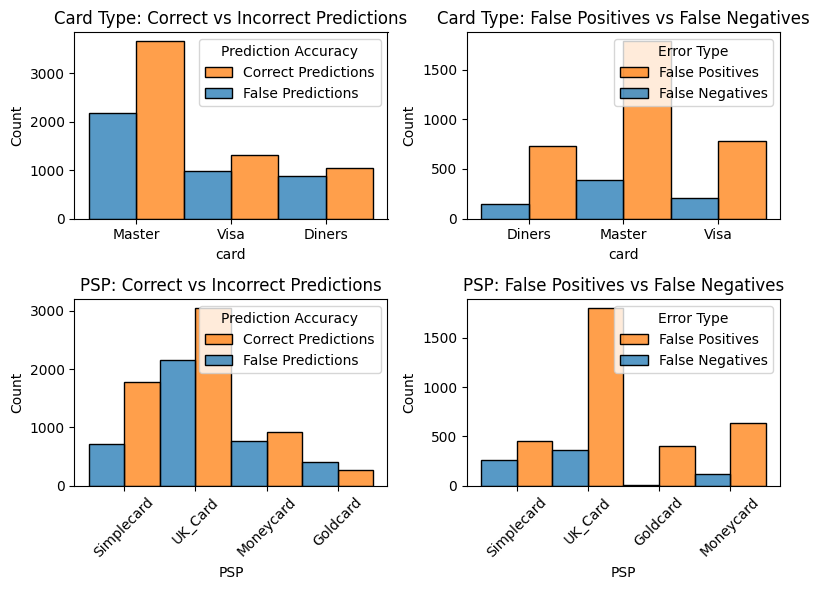

In [227]:
# Set up a 2x2 subplot layout with a figure size of 8x6 inches
f, axes = plt.subplots(2, 2, figsize=(8, 6))

# Plot histogram of 'card' comparing correct and incorrect predictions
sns.histplot(data=X_test, x='card', hue=~errors, multiple="dodge", ax=axes[0, 0])
axes[0, 0].legend(title="Prediction Accuracy", labels=['Correct Predictions', 'False Predictions'])
axes[0, 0].set_title('Card Type: Correct vs Incorrect Predictions')

# Plot histogram of 'card' for errors only, differentiating between false positives and false negatives
sns.histplot(data=X_test[errors], x='card', hue=false_positives, multiple="dodge", ax=axes[0, 1])
axes[0, 1].set_title('Card Type: False Positives vs False Negatives')
axes[0, 1].legend(title="Error Type", labels=['False Positives', 'False Negatives'])

# Plot histogram of 'PSP' comparing correct and incorrect predictions
sns.histplot(data=X_test, x='PSP', hue=~errors, multiple="dodge", ax=axes[1, 0])
axes[1, 0].set_title('PSP: Correct vs Incorrect Predictions')
axes[1, 0].legend(title="Prediction Accuracy", labels=['Correct Predictions', 'False Predictions'])
axes[1,0].tick_params(axis='x', labelrotation=45)

# Plot histogram of 'PSP' for errors only, differentiating between false positives and false negatives
sns.histplot(data=X_test[errors], x='PSP', hue=false_positives, multiple="dodge", ax=axes[1, 1])
axes[1, 1].set_title('PSP: False Positives vs False Negatives')
axes[1, 1].legend(title="Error Type", labels=['False Positives', 'False Negatives'])
axes[1,1].tick_params(axis='x', labelrotation=45)

# Adjust the layout to avoid overlap and ensure clear readability
plt.tight_layout()
plt.show()
